Lab Notebook
----------------------------

**Project Title**: Spiking dynamics of neuronal populations in the hippocampus <br>
**Project Number**: 9 <br>
**Participants**: Lyle Hopkins, Demi Brizee, Caitlin Ashcroft <br>
**Facilitators**: Dupret David (david.dupret@bndu.ox.ac.uk) and Vitor Lopes-dos-Santos (vitor.lopesdossantos@bndu.ox.ac.uk) <br>
**Department**: MRC Brain Network Dynamics Unit, Nuffield Department of Clinical Neurosciences <br>

**Context** 

--------

Information processing in the brain arises from the temporally coordianted activity of populations of neurons. This project analysed data generated by simultaneously recording the activity of around 70 neurons in the mouse hippocampus using a recording probe. The key aim of this project was to examine the basic spiking properties of different cell types within the hippocampus and investigate the relationship between the activity patterns of individual cells, groups of related cell types, and the global state of the hippocampal circuit during this recording. 

**Task 1: Data Loading**

As with all data analysis projects, the first important task is to import the data you wish to analyse and the necessary packages. Our first section of code imports the following four files:

- The '.res' file, which contains the spike times for each cluster 
- The '.clu' file, which contains the cluster label for each individual spike 
- The '.des' file, which matches clusters to their corresponding cell ID (aka what cell type they are)
- The 'theta.cycle' file, which contains an n x 6 array of the times that correspond to each stage of the theta oscillation of these cell

This code produces four variables - res, clu, des, and cycles - each containing an array that correspond to the information contained in the original files. 


In [15]:
### Loading data and necessary packages for analysis of hippocampal ephys data ##

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
import seaborn as sns

def LoadSpikeTimes(bs, MinCluId=2):

        res = pd.read_csv(bs+'.res', header=None, squeeze=True).values
        clu = pd.read_csv(bs+'.clu', squeeze=True).values
        if MinCluId is not None:
                mask = clu >= MinCluId
                clu = clu[mask]
                res = res[mask]
                
        return res,clu
    
def LoadUnits(b, par=None):
    
        '''Load "units" information (mostly from des-file).

        INPUT:
        - [b]:       <str> containing "block base"

        OUTPUT:
        - [trodes]:  <DataFrame>'''

        ## If not provided, load the par-file information
        if par is None:
                par = LoadPar(b)

        ## For each tetrode, read in its "per tetode" des-file
        trode_index = range(1, len(par['trode_ch'])+1)
        units = [pd.read_csv(b+'.des.'+str(t), header=None, names=['des']) for t in trode_index]
        units = pd.concat(units, keys=trode_index, names=['trode','trode_unit']).reset_index()

        all_trodes = pd.read_csv(b+'.des', header=None, names=['des'])
        if ~np.all(all_trodes.des == units.des):
                units.des = all_trodes.des

        ## Let the "index per tetrode" and the index of this <DataFrame> start from 2(!) instead of 0
        units['trode_unit'] += 2
        units.index += 2

        ## Return the "unit"-information as <DataFrame>
        return unitspd.read_csv(b+'.clu'+t, squeeze=True).values
    
def loadDes(b):
        # returns des matched to clu id
        des = pd.read_csv(b+'.des', header=None, names=['des'])
        des.index +=2
        return des
    
b = '/Users/caitlinashcroft/Stats/Project/Project 9/mvl10-200109' #basename 
bs = b+'_'+str(2)

res,clu = LoadSpikeTimes(bs)
cycles = np.load(bs+'.theta.cycles.7')
des = loadDes(b) # des indices correspond to the cell ids in the clu file

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  print(len(bins), len(hist))

** Task 2: Data Formatting **

Once the data had been uploading, we manipulated it into a useable format to aid future analysis. More specifically, we combined the res, des, and clu variables into a DataFrame that matched each spike to its corresponding cluster and cell ID.

While later refinement of our analysis method rendered this DataFrame redundant, it was a useful starting point for visualising how these variables (res, des, clu) related to one another. 

In [16]:
#Set up dataframes for res, clu, and des - inspect to see makeup of data

dfres = pd.DataFrame(res)
dfclu = pd.DataFrame(clu)
dfdes = pd.DataFrame(des)


#Combine to generate dataframe containing all datasets

#Note: first to columns are 'noise' clusters 

recording_data = pd.concat([dfres,dfclu], axis = 1)
recording_data.columns = ['Res', 'Cluster']
recording_data

# To assign cell id to each cluster, match cluster in .clu file to corresponding id in .des file

cluster = []
L = []

for index, row in recording_data.iterrows():

   cluster = row['Cluster']
   id = dfdes.loc[cluster]
   value = str(id[0])
   L.append(value)

#Add cell id to dataframe

dfdes = pd.DataFrame(L)
recording_data = pd.concat([recording_data, dfdes], axis = 1)
recording_data.columns = ['Res', 'Cluster', 'Description']
recording_data

,Res,Cluster,Description
0,6,37,p1
1,21,3,b3
2,425,13,b3
3,650,3,b3
4,796,8,b3
...,...,...,...
441759,30099436,18,b3
441760,30099450,3,b3
441761,30099452,67,p1
441762,30099453,3,b3


**Task 3: Mean Firing Rates and Inter-Spike Intervals**

-----------------------------------

The first question we were interested in is how the firing rate and interspike intervals differed between neuronal subtypes. 

We decided to focus on two specific subtypes: pyramidal (P1) cells and basket (B1) cells. 

To examine firing rate, we calculated the mean firing rate of each cluster within these subtypes. 



In [17]:
# Compute mean firing for p1 cells 

recording_data_p1 = []

#Extract spikes that correspond to p1 cell id

p1_cells = recording_data.loc[recording_data['Description'] == 'p1']


#identify unique clusters in p1 group

singleP1Cells = p1_cells['Cluster'].unique()

#calculate mean firing rate for each cluster 

for i in singleP1Cells:
    df = []
    df = p1_cells.loc[p1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res']))
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike, 'spikes per second')

 #save spike times (in milliseconds) in an array for further analyses 

    recording_data_p1.append(np.array(df['Res']/20))

The mean firing rate for Cluster  37 is:  1.3169698280216993 spikes per second
The mean firing rate for Cluster  60 is:  1.204726848454167 spikes per second
The mean firing rate for Cluster  36 is:  1.4977924023150204 spikes per second
The mean firing rate for Cluster  52 is:  0.5588810084448916 spikes per second
The mean firing rate for Cluster  28 is:  0.09459851915478115 spikes per second
The mean firing rate for Cluster  31 is:  0.5595439122140448 spikes per second
The mean firing rate for Cluster  55 is:  3.0891177567434434 spikes per second
The mean firing rate for Cluster  58 is:  0.5950929829461311 spikes per second
The mean firing rate for Cluster  44 is:  2.8680533181221857 spikes per second
The mean firing rate for Cluster  56 is:  0.017091278983476357 spikes per second
The mean firing rate for Cluster  26 is:  0.47636833811187546 spikes per second
The mean firing rate for Cluster  53 is:  2.4598444208302634 spikes per second
The mean firing rate for Cluster  69 is:  1.81417

In [18]:
#Then computer mean firing rate for B1 cells 

#Extract spikes that correspond to b1 cell id

b1_cells = recording_data.loc[recording_data['Description'] == 'b1']

#identify unique clusters in b1 group

singleB1Cells = b1_cells['Cluster'].unique()

recording_data_b1 = []

#calculate mean firing rate for each cluster 

for i in singleB1Cells:
    df = []
    df = b1_cells.loc[b1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res'])) 
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike, 'spikes per second')

    #save spike times (in milliseconds) in an array for further analyses 

    recording_data_b1.append(np.array(df['Res']/20))

The mean firing rate for Cluster  41 is:  32.01103262292616 spikes per second
The mean firing rate for Cluster  65 is:  13.481017572937699 spikes per second
The mean firing rate for Cluster  57 is:  7.555355268012541 spikes per second
The mean firing rate for Cluster  61 is:  5.956623769954366 spikes per second


These analyses demonstrate these B1 cells have a higher mean firing rate than P1 cells. This is to be expected as B1 cells, basket cells, are interneurons and are thus likely to have higher firing rates. 

We then chose to examine the distribution of the interspike interval (the time between spikes) for both P1 and B1 cells.

After a couple of false starts (see our project_9_analyses.ipynb file on GitHub for our early attempts to generate these graph), we were able to plot the interspike interval distributions of both p1 and b1 cells. We achived this be examinign the interspike intervals of spikes occuring in set time bins. We use exactly the same bins for all clusters to enable comparison across them.

These graph demonstrates the ISI distribution of P1 cells have two peaks: one around 2ms and another around 8ms. B1 cells, on the other hand, only displayed a single, albeitflatter, peak in the ISI distribution around 5ms. 

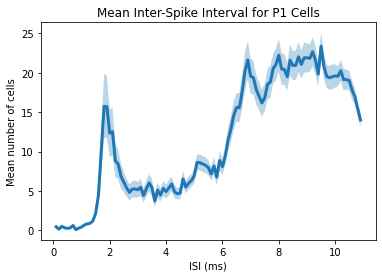

Text(0.5, 0, 'ISI (ms)')

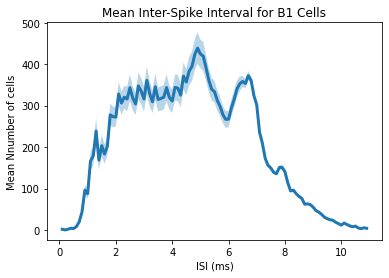

In [19]:
#Define edges of spike time bins to enable comparison across clusters

binedges = np.arange(np.log2(1),np.log2(2000),.1) 

#Examine number of clusters (67)

clus = np.unique(clu) 

#Create empty array equal in length to the number of clusters

counts = np.zeros((len(clus),len(binedges)-1)) 

#Iterate through clusters

for clui,clu_ in enumerate(clus): 

     
#Calculate spiketimes by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

#Calculate ISI for each cluster

         

        isi_ = np.log2(np.diff(spktimes)) 

         
#Populate empty counts array with interspike intervals with a given bin

        counts[clui],_ = np.histogram(isi_,binedges) 

#Create a 'mask' to identify clusters of a given cell type         

mask_p1 = des['des'].values=='p1' 
mask_b1 = des['des'].values=='b1' 

#Calculate mean ISI for this cell type

meanISI_p1 = np.mean(counts[mask_p1,:],axis=0)
meanISI_b1 = np.mean(counts[mask_b1,:],axis=0) 

#Calculate sem of ISI for this cell type

std_p1 = np.std(counts[mask_p1,:],axis=0)
std_b1 = np.std(counts[mask_b1,:],axis=0) 

n_p1 = len(meanISI_p1) 
n_b1 = len(meanISI_b1) 

sem_p1 = std_p1/np.sqrt(n_p1) 
sem_b1 = std_b1/np.sqrt(n_b1) 

#Plot mean ISI w SEM 

plt.plot(binedges[1:],meanISI_p1,lw=3)

plt.fill_between(binedges[1:],meanISI_p1-sem_p1,meanISI_p1+sem_p1,alpha=.3) 
plt.title('Mean Inter-Spike Interval for P1 Cells')
plt.xlabel('ISI (ms)')
plt.ylabel('Mean number of cells')

plt.pause(1) 

plt.plot(binedges[1:],meanISI_b1,lw=3) 
plt.fill_between(binedges[1:],meanISI_b1-sem_b1,meanISI_b1+sem_b1,alpha=.3)
plt.title('Mean Inter-Spike Interval for B1 Cells')
plt.ylabel('Mean Nnumber of cells')
plt.xlabel('ISI (ms)')

**Task 5: Theta Cycles**

-------------------------------

Theta cycles are network oscillations that arise out of the coordinate activity of a population of neurons. For our next task, we decided to examine how the activity of P1 and B1 cells maps on the global theta oscillations. 

To achieve these, we created a 'theta binned activity matrix' containing the average activity of P1 and B1 cells at each stage in the theta cycle: the first ascending zero crossing, the peak, the descending zero crossing, the trough, the second ascending zero crossing, and the peak of next cycle. 

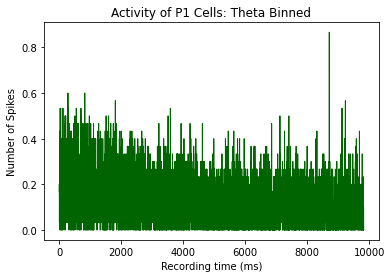

Text(0.5, 1.0, 'Activity of P1 Cells: Theta Binned')

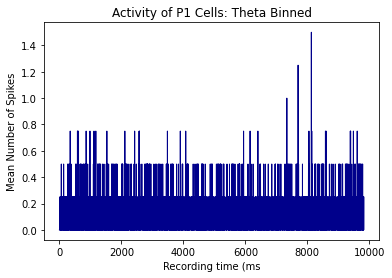

In [20]:
#####Analysis of theta cycles#### 

#Define edges of spike time bins to enable comparison across clusters
cyedges = (cycles[:,np.array([0,4])].flatten())/1.25

#Create empty array equal in length to the number of cycles

counts = np.zeros((len(clu),len(cycles))) 

#Iterate through clusters

clus = np.unique(clu)

for clui,clu_ in enumerate(clus): 

     
# #Calculate spiketimes by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

         
#Populate empty counts array with interspike intervals with a given bin

        counts_ = np.histogram(spktimes,cyedges)[0] 
        counts_ = np.concatenate((counts_[0:-1:2], [counts_[-1]]))
        counts[clui] = counts_

# #Create a 'mask' to identify clusters of a given cell type         
mask_p1 = des.des[des.des == 'p1'].index.tolist()
mask_b1 = des.des[des.des == 'b1'].index.tolist()

#Calculate mean spikes in each bin across cell types 

mean_spks_p1 = np.mean(counts[mask_p1,:], axis = 0)
mean_spks_b1 = np.mean(counts[mask_b1,:], axis = 0)

# # #Plot mean spikes for each theta bin

binnumber = np.arange(len(cycles))

plt.plot(binnumber,mean_spks_p1,lw=1, color = 'darkgreen')
plt.xlabel('Recording time (ms)')
plt.ylabel('Number of Spikes')
plt.title('Activity of P1 Cells: Theta Binned')

plt.pause(1)

plt.plot(binnumber,mean_spks_b1,lw=1, color = 'darkblue')
plt.xlabel('Recording time (ms')
plt.ylabel('Mean Number of Spikes')
plt.title('Activity of P1 Cells: Theta Binned')


**Principal Component Analysis**

--------------------------------------------------

Principal component analysis is a dimensionality reduction technique that reduces a large set of data in a smaller number of latent variables. 
We decided to perform PCA on the theta binned activity matrix of P1 cells to determine how many principal components were required to explain the majority of the variance in this data. 


([<matplotlib.axis.XTick at 0x7f961d52d520>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15')])

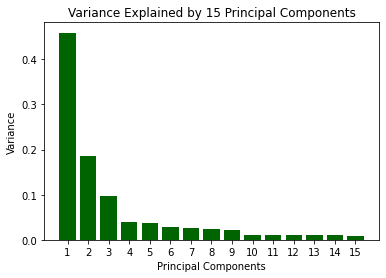

In [21]:
###PCA on P1 Cells###

#Extract spike times for p1 cells from counts 

p1_counts = counts[mask_p1,:]

# Perform PCA (assuming no of appropriate factors has already been determined)

pca = PCA(n_components = 15).fit(p1_counts)
X_pca = pca.transform(p1_counts)
PCA_components = pd.DataFrame(X_pca)

#Plot explained variance against PCs

plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.xlabel('Principal Components')
plt.ylabel('Variance')
plt.title('Variance Explained by 15 Principal Components')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'))

By plotting the cumulative explained variance for each principal component, we determined that 12 principal components were required to explain 95% of the variance in the p1 theta binned activity data. We also generated a scree plot to examine the eigenvalues associated with each principal component. 

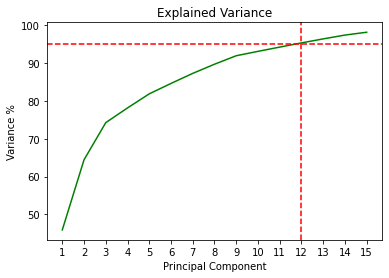

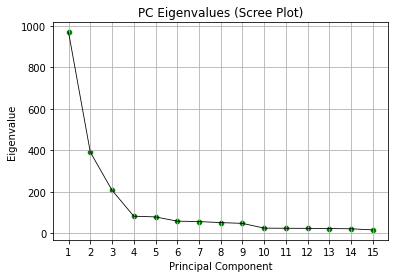

In [22]:
#Plot the % variance explained by each component 
#Examine number of PCs required to explain 95% of the variance 

plt.figure()
sns.lineplot(data = (np.cumsum(pca.explained_variance_ratio_)*100), color = 'green')
plt.xlabel('Principal Component')
plt.ylabel('Variance %') #for each component
plt.title('Explained Variance')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=11, color='r', linestyle='--')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'))
plt.show()

#Generate a screeplot plotting the eigenvalues for each PC 

plt.subplots()
sns.scatterplot(features, pca.explained_variance_, color = 'green')
plt.plot(features, pca.explained_variance_, linewidth=0.8, color = 'black')
plt.title('PC Eigenvalues (Scree Plot)')
plt.xlabel('Principal Component')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12', '13', '14', '15'))
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

**Regression and GLM**

-----------

**Gaussian Mixture Model** 

-------------------------------


**Next Steps** 

-----------

- Further analyses 